# Stan spline implementation

Test out the Stan code by trying to reproduce the same results as the equivalent python case.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import stan_utility

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1D spline basis 

In [2]:
# Compile stan model
spline_eval = stan_utility.compile_model(filename = '1D_spline_basis.stan', 
                                         model_name = 'spline_eval')

Using cached StanModel


In [3]:
# Define spline
p = 3 
knots = np.array([0.0, 0.5, 1.5, 3.5, 4.0])
Nevals = 1000
xvals = np.linspace(knots[0], knots[-1], Nevals)

In [4]:
# Evaluate and extract output
spline_input = {'p' : p, 'Lknots' : len(knots), 'knots' : knots, 
                'Nevals' : Nevals, 'xvals' : xvals}
output = spline_eval.sampling(data = spline_input, 
                              iter=1, chains=1, algorithm="Fixed_param")
yvals = output.extract(['yvals'])['yvals'][0]

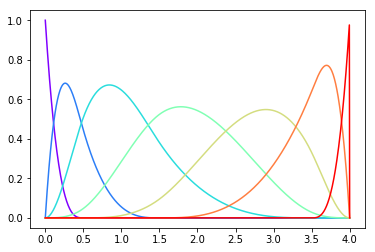

In [5]:
# Plot
Nknots = len(knots)+p-1 
color = iter(cm.rainbow(np.linspace(0,1,Nknots))) # loop through colors
for idx in range(Nknots):
    plt.plot(xvals, yvals[idx], color=next(color), linestyle='solid')
    
# Yay! it works.

## Comparison with Scipy - 1D arbitrary function
Represent arbitrary function as superposition of b-splines and compare with scipy to verify.

In [6]:
# Compile stan model
bspline_func_1d = stan_utility.compile_model(filename = 'bspline_func_1d.stan', 
                                         model_name = 'bspline_func_1d')

Using cached StanModel


In [7]:
# generate fake data from arbitrary curve 
np.random.seed(1)
xmin = -2.
xmax = 2.
xobs = np.linspace(xmin, xmax, 15)
stderr = 1.0
yobs = xobs**3+np.random.normal(0.0, stderr, len(xobs))

In [8]:
# Interpolate with scipy
from scipy.interpolate import UnivariateSpline
func = UnivariateSpline(xobs, yobs, s=30, k=p)

# Evaluate with scipy
Nevals = 1000
new_x = np.linspace(xmin, xmax, Nevals)
new_y_scipy = func(new_x)

In [9]:
# Evaluate with Stan
knots = np.unique(func.get_knots()) # strip possible padded knots
coeffs = func.get_coeffs()

spline_input = {'p' : p, 'Lknots' : len(knots), 'knots' : knots, 'c' : coeffs,
                'Nevals' : Nevals, 'xvals' : new_x}
output = bspline_func_1d.sampling(data = spline_input, 
                                  iter=1, chains=1, algorithm="Fixed_param")
new_y_stan = output.extract(['yvals'])['yvals'][0]

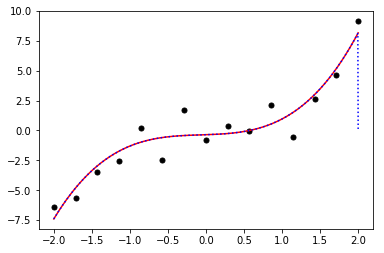

In [10]:
# Plot
plt.figure()
plt.plot(xobs, yobs, ".", markersize=10, color='black')
plt.plot(new_x, new_y_scipy, "r-")
plt.plot(new_x, new_y_stan, color='blue', linestyle='dotted')

# notice the prefect match :) and be happy!

## 2D spline basis
Lets generalize to 2D by means of tensor-product splines and first plot two elements of the tensor-product spline basis.

In [11]:
from mpl_toolkits.mplot3d import Axes3D

In [12]:
# Compile Stan model
bspline_func_2d = stan_utility.compile_model(filename = 'bspline_func_2d.stan', 
                                         model_name = 'bspline_func_2d')

Using cached StanModel


In [13]:
# Define inputs
p = 3 # spline degree
xknots = np.array([0.0, 0.5, 1.5, 3.5, 4.0]) # arbitrary knot sequence
yknots = np.array([0.0, 1.0, 2.5, 4.0]) # another arbitrary knot sequence

Nx = len(xknots)+p-1 # number of coefficients that need to be defined along x
Ny = len(yknots)+p-1 # number of coefficients that need to be defined along y
N = Nx * Ny # total number of entries for coefficient matrix

# Pick out 2 basis elements by setting only certain coefficients to 1
cs = []
c1 = np.zeros(N) 
c1[25]=1 # all coefficients zero except for one
c1 = c1.reshape(Nx, Ny)
c2 = np.zeros(N) 
c2[35]=1 # all coefficients zero except for one
c2 = c2.reshape(Nx, Ny)

cs.append(c1)
cs.append(c2)

Nevals = 100
xaxis = np.linspace(xknots[0], yknots[-1], Nevals)
yaxis = np.linspace(xknots[0], yknots[-1], Nevals)

In [14]:
# Evaluate and extract output
zs = []
for c in cs:
    spline_input = {'p' : p, 
                    'Lknots_x' : len(xknots), 'xknots' : xknots, 
                    'Lknots_y' : len(yknots), 'yknots' : yknots,
                    'c' : c,
                    'Nevals' : Nevals, 
                    'xvals' : xaxis, 'yvals' : yaxis}
    output = bspline_func_2d.sampling(data = spline_input, 
                                      iter=1, chains=1, algorithm="Fixed_param")
    zs.append(output.extract(['zvals'])['zvals'][0])

Text(0.5,0,'y')

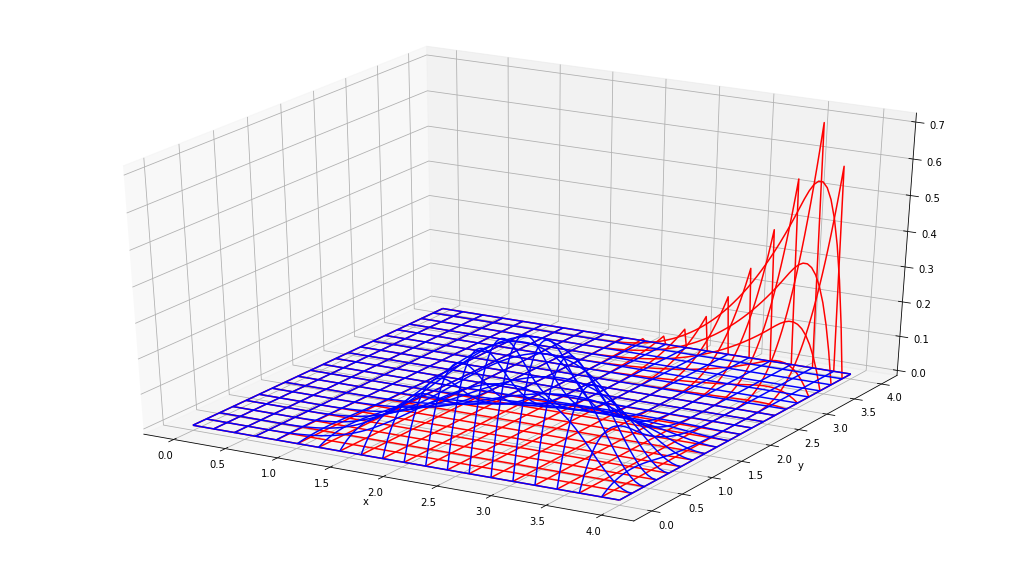

In [15]:
# Plot
xx, yy = np.meshgrid(xaxis, yaxis)
xx=xx.T
yy=yy.T

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['blue', 'red']
for z, color in zip(zs, colors):
    surf = ax.plot_wireframe(xx, yy, z, rstride=5, cstride=5, color=color) 
ax.set_xlabel('x')
ax.set_ylabel('y')

## $A_\mathrm{eff}$ example
And now the example from the effective area for nue CC interactions. Coefficients and knots are taken from a smoothing spline fit created using scipy's RectBivariateSpline implementation.

In [16]:
# Define stuff
p = 3 # spline degree
tx_orig = np.array([2.90998783, 4.03010253, 5.00991847, 6.96995941]) # knot sequence
ty_orig = np.array([-0.9,  0.1,  0.9]) # knot sequence
Nx = len(tx_orig)+p-1 # number of coefficients that need to be defined
Ny = len(ty_orig)+p-1 # number of coefficients that need to be defined
N = Nx * Ny

c = np.asarray(
    [-3.58077707, -3.41361407, -3.67857551, -4.18870088, -4.33580191, -1.96090326,
     -1.97689,    -2.05099873, -2.14549395, -2.17675871, -0.34077015, -0.32737177,
     -0.30599357, -0.29709922, -0.29278352,  0.48041494,  0.94140028,  1.02319478,
     0.88547053,  0.95448815, -0.26299716,  0.99602738,  1.47548988,  1.31308221,
     1.42759428, -1.33184261,  0.47994404,  1.74747881,  1.44319947,  1.39107924])
c = c.reshape(Nx, Ny)

Nevals = 100
xaxis = np.linspace(tx_orig[0], tx_orig[-1], Nevals)
yaxis = np.linspace(ty_orig[0], ty_orig[-1], Nevals)

In [17]:
# Evaluate
spline_input = {'p' : p, 
                'Lknots_x' : len(tx_orig), 'xknots' : tx_orig, 
                'Lknots_y' : len(ty_orig), 'yknots' : ty_orig,
                'c' : c,
                'Nevals' : Nevals, 
                'xvals' : xaxis, 'yvals' : yaxis}
output = bspline_func_2d.sampling(data = spline_input, 
                                  iter=1, chains=1, algorithm="Fixed_param")
z = output.extract(['zvals'])['zvals'][0]

Text(0.5,0,'y')

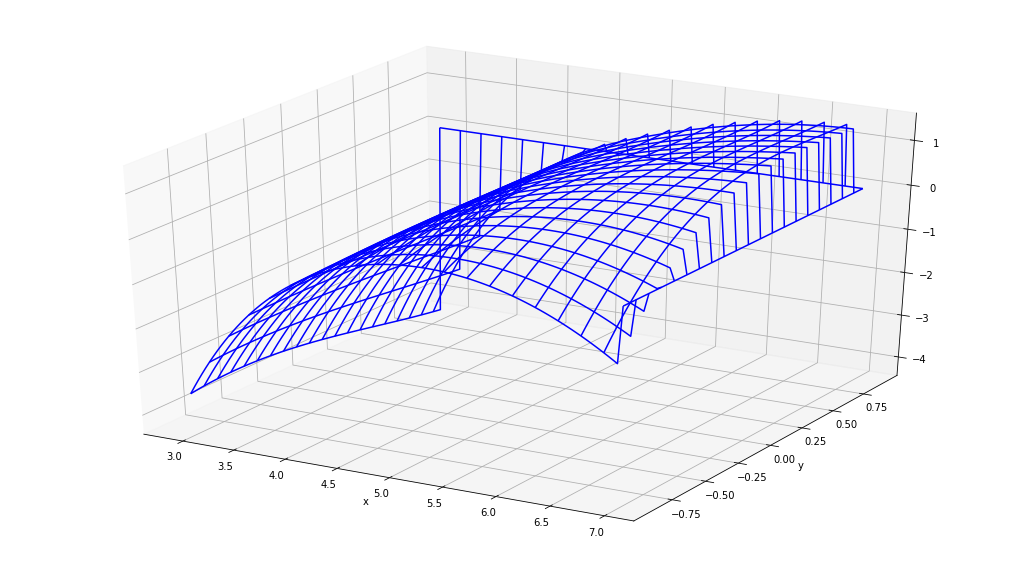

In [18]:
xx, yy = np.meshgrid(xaxis, yaxis)
xx=xx.T
yy=yy.T

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, z, rstride=5, cstride=5, color='blue')

ax.set_xlabel('x')
ax.set_ylabel('y')

In [24]:
import h5py
# Save to file for use elsewhere
with h5py.File('Aeff_shape.h5', 'w') as f:
    f.create_dataset('log10E', data=xaxis)
    f.create_dataset('cosz', data=yaxis)
    f.create_dataset('log10Aeff', data=z)